# Bootstrap

## Описание колонок
- value – значения метрики (числовая переменная – непрерывная)
- experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

## Задача
1. Сравните результат между тестом и контролем по двум кейсам:
    - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
    - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Загружаем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-pershanova-17/Statistics/hw_bootstrap.csv', sep=';', decimal = ",")

In [3]:
# Делим данные по группам и ниже посмотрим их основные характеристики
df_control = df.query('experimentVariant == "Control"')
df_test = df.query('experimentVariant == "Treatment"')

In [4]:
df_control

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
495,496,10.973929,Control
496,497,10.261074,Control
497,498,8.780090,Control
498,499,11.169078,Control


In [5]:
df_control.value.describe()

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

(array([  1.,   2.,  22.,  65., 105., 156.,  84.,  45.,  13.,   7.]),
 array([ 6.43654076,  7.10592126,  7.77530175,  8.44468225,  9.11406275,
         9.78344324, 10.45282374, 11.12220424, 11.79158473, 12.46096523,
        13.13034573]),
 <a list of 10 Patch objects>)

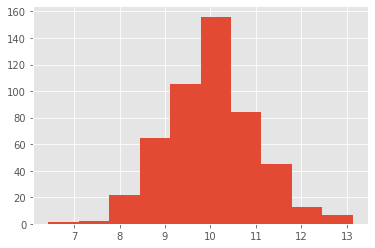

In [6]:
plt.hist(df_control.value)

In [7]:
df_test

,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [8]:
df_test.value.describe()

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

(array([495.,   0.,   0.,   2.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([   6.43654076,  305.79288668,  605.14923261,  904.50557853,
        1203.86192446, 1503.21827038, 1802.5746163 , 2101.93096223,
        2401.28730815, 2700.64365408, 3000.        ]),
 <a list of 10 Patch objects>)

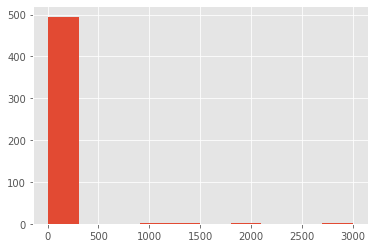

In [9]:
plt.hist(df_test.value)

По графикам и значениям видно, что в тестовой группе есть выбросы, которые значительно отличаются от большинства значений.
Это приводит к сильному отличию среднего в группах, при этом медианы примерно равны.

In [11]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

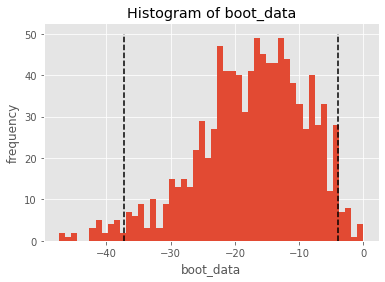

In [12]:
# Бутстрап на средних
booted_data_mean = get_bootstrap(df_control.value, df_test.value, boot_it = 1000, statistic = np.mean)

In [13]:
booted_data_mean["p_value"]

0.04222636261221943

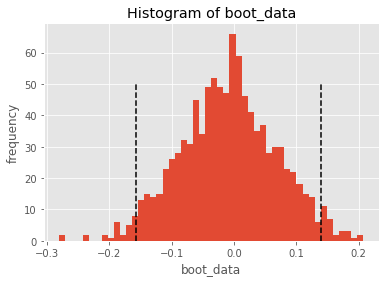

In [14]:
# Бутстрап на медианах
booted_data_median = get_bootstrap(df_control.value, df_test.value, boot_it = 1000, statistic = np.median)

In [15]:
booted_data_median["p_value"]

0.9042556882284101

In [16]:
# Критерий Манн-Уитни
mannwhitneyu(df_control.value, df_test.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

# Выводы:
При сравнении результатов тестов видно, что результаты конфликтуют между собой. Бутстрап на средних показывает, что между группами данных имеется статистически значимые отличия, два других метода противоречат ему.

Если посмотреть на исходные данные (графики, характеристики) видно, что в тестовой группе имеются значения, которые дают выбросы и сильно увеличивают среднее. Можно предположить, что использовать бутстрап на средних для сравнения групп не корректно.

При сравнении критериев видно, что порядок pvalue совпадает для бутстрапа на медианах и критерия Манна-Уитни. Ноль попадает в доверительный интервал для бутстрапа на медианах, pvalue > 0,05 для этого метода и для теста Манна-Уитни, можно делать вывод о том, что различие между контрольной и тестовой группой статистически не значимо.

Тест Манна-Уитни не требует нормального распределения данных, на него можно ориентироваться для проверки результатов бутстрапа.